In [2]:
from pathlib import Path
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ElectionForecasting.src.root import ROOT_DIR


In [3]:

def consolidate_data_with_index(file_paths, model_suffix):
    consolidated_data = pd.DataFrame()
    for file in file_paths:
        year = file.split('_')[2]
        temp_data = pd.read_csv(file, index_col=0)
        new_column_name = f'log_likelihood_{year}_{model_suffix}'  # Adding the model_suffix here
        temp_data = temp_data.rename(columns={'log_likelihood': new_column_name})
        if consolidated_data.empty:
            consolidated_data = temp_data
        else:
            consolidated_data = pd.merge(consolidated_data, temp_data, left_index=True, right_index=True, how='outer')
    return consolidated_data


def combine_dataframes(default, updated):
    # Merge the old and new consolidated DataFrames using index
    consolidated_data_both = pd.merge(default, updated, left_index=True, right_index=True, how='outer', suffixes=('_DefaultModel', '_RedistributingPollsOnly'))
    # Melt the DataFrame for easier plotting
    consolidated_data_both_melted = pd.melt(consolidated_data_both.reset_index(), id_vars=['index'], var_name='Metric', value_name='Log Likelihood')

    # Extract the year and model type from the 'Metric' column
    consolidated_data_both_melted['Year'] = consolidated_data_both_melted['Metric'].str.extract(r'(\d{4})')
    consolidated_data_both_melted['Model'] = consolidated_data_both_melted['Metric'].str.extract(r'(new_model)')
    consolidated_data_both_melted['Model'].fillna('DefaultModel', inplace=True)
    return consolidated_data_both_melted

def plot_comparison(consolidated_data_both_melted):
    # Create the line plot for comparison
    sns.set(style="whitegrid")
    plt.figure(figsize=(15, 10))
    sns.lineplot(x='Year', y='Log Likelihood', hue='index', style='Model', data=consolidated_data_both_melted)
    plt.title('Comparison of Log-Likelihood Scores Between Models Over Time')
    plt.xlabel('Year')
    plt.ylabel('Log-Likelihood')
    plt.legend(title='Province/Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


# Function to plot heatmap
def plot_heatmap(data, model_suffix):
    plt.figure(figsize=(12, 8))
    sns.heatmap(data.filter(like=model_suffix), annot=True, fmt=".2f", cmap='coolwarm')
    plt.title(f"Heatmap of Log-Likelihoods for {model_suffix}")
    plt.show()

# Function to plot delta plot
def plot_delta(data, default_model_suffix, new_model_suffix):
    delta_data = pd.DataFrame()
    for year in range(2018, 2023):
        delta_data[f'delta_{year}'] = data[f'log_likelihood_{year}_{new_model_suffix}'] - data[f'log_likelihood_{year}_{default_model_suffix}']
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=delta_data, markers=True)
    plt.title('Delta Plot of Log-Likelihood Differences Between Models')
    plt.ylabel('Delta Log-Likelihood')
    plt.xlabel('Province/National')
    plt.show()

# Function to plot cumulative sum line plot
def plot_cumulative_sum(data, model_suffixes):
    for model_suffix in model_suffixes:
        data[f'cumulative_{model_suffix}'] = data.filter(like=model_suffix).sum(axis=1)
    plt.figure(figsize=(12, 8))
    for model_suffix in model_suffixes:
        sns.lineplot(data=data, x=data.index, y=f'cumulative_{model_suffix}', label=f'Cumulative {model_suffix}')
    plt.title('Cumulative Sum of Log-Likelihoods Over Time')
    plt.ylabel('Cumulative Log-Likelihood')
    plt.xlabel('Province/National')
    plt.legend()
    plt.show()

def load_log_likelihoods(default_model_name, comparison_model_name, date):
    default_model_files = glob.glob(f'{ROOT_DIR}/results/evaluation/{date}/{default_model_name}/*/*/log_likelihood_scores.csv')
    default_model_files.sort()
    # print(default_model_files)
    consolidated_data_default = consolidate_data_with_index(default_model_files, default_model_name)
    new_model_files = glob.glob(f'{ROOT_DIR}/results/evaluation/{date}/{comparison_model_name}/*/*/log_likelihood_scores.csv')
    new_model_files.sort()
    return default_model_files, new_model_files

def generate_comparison_plots(default_model_name, comparison_model_name, date):
    default_model_files, new_model_files = load_log_likelihoods(default_model_name, comparison_model_name, date)
    # print(default_model_files)
    # print(new_model_files)
    consolidated_data_default = consolidate_data_with_index(default_model_files, default_model_name)
    consolidated_data_new = consolidate_data_with_index(new_model_files, comparison_model_name)
    consolidated_data_both_melted = combine_dataframes(consolidated_data_default, consolidated_data_new)
    plot_comparison(consolidated_data_both_melted)
    # Call functions to plot
    # plot_heatmap(consolidated_data_both_melted, 'DefaultModel')
    # plot_heatmap(consolidated_data_both_melted, 'RedistributingPollsOnly')
    # plot_delta(consolidated_data_both_melted, 'DefaultModel', 'RedistributingPollsOnly')
    # plot_cumulative_sum(consolidated_data_both_melted, ['DefaultModel', 'RedistributingPollsOnly'])

def consolidate_data_with_index(file_paths, model_suffix):
    consolidated_data = pd.DataFrame()
    for file in file_paths:
        year = Path(file).parent.parent.stem # file.split('_')[2]
        temp_data = pd.read_csv(file, index_col=0)
        new_column_name = f'log_likelihood_{year}_{model_suffix}'  # Adding the model_suffix here
        temp_data = temp_data.rename(columns={f'log_likelihood_{year}': new_column_name})
        if consolidated_data.empty:
            consolidated_data = temp_data
        else:
            consolidated_data = pd.merge(consolidated_data, temp_data, left_index=True, right_index=True, how='outer')
    return consolidated_data

# Function to plot heatmap
def plot_heatmap(data, model_suffix):
    plt.figure(figsize=(12, 8))
    filtered_data = data[data['Model'] == model_suffix]
    pivot_table = pd.pivot_table(filtered_data, values='Log Likelihood', index=['index'], columns=['Year'])
    sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap='coolwarm')
    plt.title(f"Heatmap of Log-Likelihoods for {model_suffix}")
    plt.show()

def plot_delta(data, default_model_suffix, new_model_suffix):
    delta_data = pd.DataFrame()
    # Pivot the DataFrame to have a multi-index and Models as columns
    pivot_table = pd.pivot_table(data, values='Log Likelihood', index=['index', 'Year'], columns=['Model'])
    
    # Calculate the delta
    delta_data = pd.DataFrame()
    data = pivot_table
    print(pivot_table)
    # Calculate the delta between the two models for each year
    data['Delta'] = data[new_model_suffix] - data[default_model_suffix]


    plt.figure(figsize=(12, 8))
    # Reset index for plotting
    ax = plt.gca()
    data_reset = data.reset_index()
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    sns.lineplot(x='index', y='Delta', hue='Year', data=data_reset, markers=True)
    plt.title('Delta Plot of Log-Likelihood Differences Between Models')
    plt.ylabel('Delta Log-Likelihood')
    plt.xlabel('Province/National')

    plt.show()


# Function to plot cumulative sum line plot
def plot_cumulative_sum(data, model_suffixes):
    for model_suffix in model_suffixes:
        data[f'cumulative_{model_suffix}'] = data.filter(like=model_suffix).sum(axis=1)
    plt.figure(figsize=(12, 8))
    for model_suffix in model_suffixes:
        sns.lineplot(data=data, x=data.index, y=f'cumulative_{model_suffix}', label=f'Cumulative {model_suffix}')
    plt.title('Cumulative Sum of Log-Likelihoods Over Time')
    plt.ylabel('Cumulative Log-Likelihood')
    plt.xlabel('Province/National')
    plt.legend()
    plt.show()


def load_log_likelihoods(default_model_name, comparison_model_name, date):
    default_model_files = glob.glob(f'{ROOT_DIR}/results/evaluation/{date}/{default_model_name}/*/*/log_likelihood_scores.csv')
    default_model_files.sort()
    # print(default_model_files)
    consolidated_data_default = consolidate_data_with_index(default_model_files, default_model_name)
    new_model_files = glob.glob(f'{ROOT_DIR}/results/evaluation/{date}/{comparison_model_name}/*/*/log_likelihood_scores.csv')
    new_model_files.sort()
    return default_model_files, new_model_files


def make_plots(default_name, new_name):
    default_model_files, new_model_files = load_log_likelihoods(default_name, new_name, date)
    consolidated_data_default = consolidate_data_with_index(default_model_files, default_name)
    consolidated_data_new = consolidate_data_with_index(new_model_files, new_name)
    consolidated_data_both = combine_dataframes(consolidated_data_default, consolidated_data_new)#, default_name, new_name)
    consolidated_data_both.set_index('index', inplace=True)
    # Call functions to plot
    plot_comparison(consolidated_data_both)
    plot_heatmap(consolidated_data_both, default_name)
    plot_heatmap(consolidated_data_both, new_name)
    plot_delta(consolidated_data_both, default_name, new_name)
    # plot_cumulative_sum(consolidated_data_both, ['DefaultModel', 'RedistributingPollsOnly'])


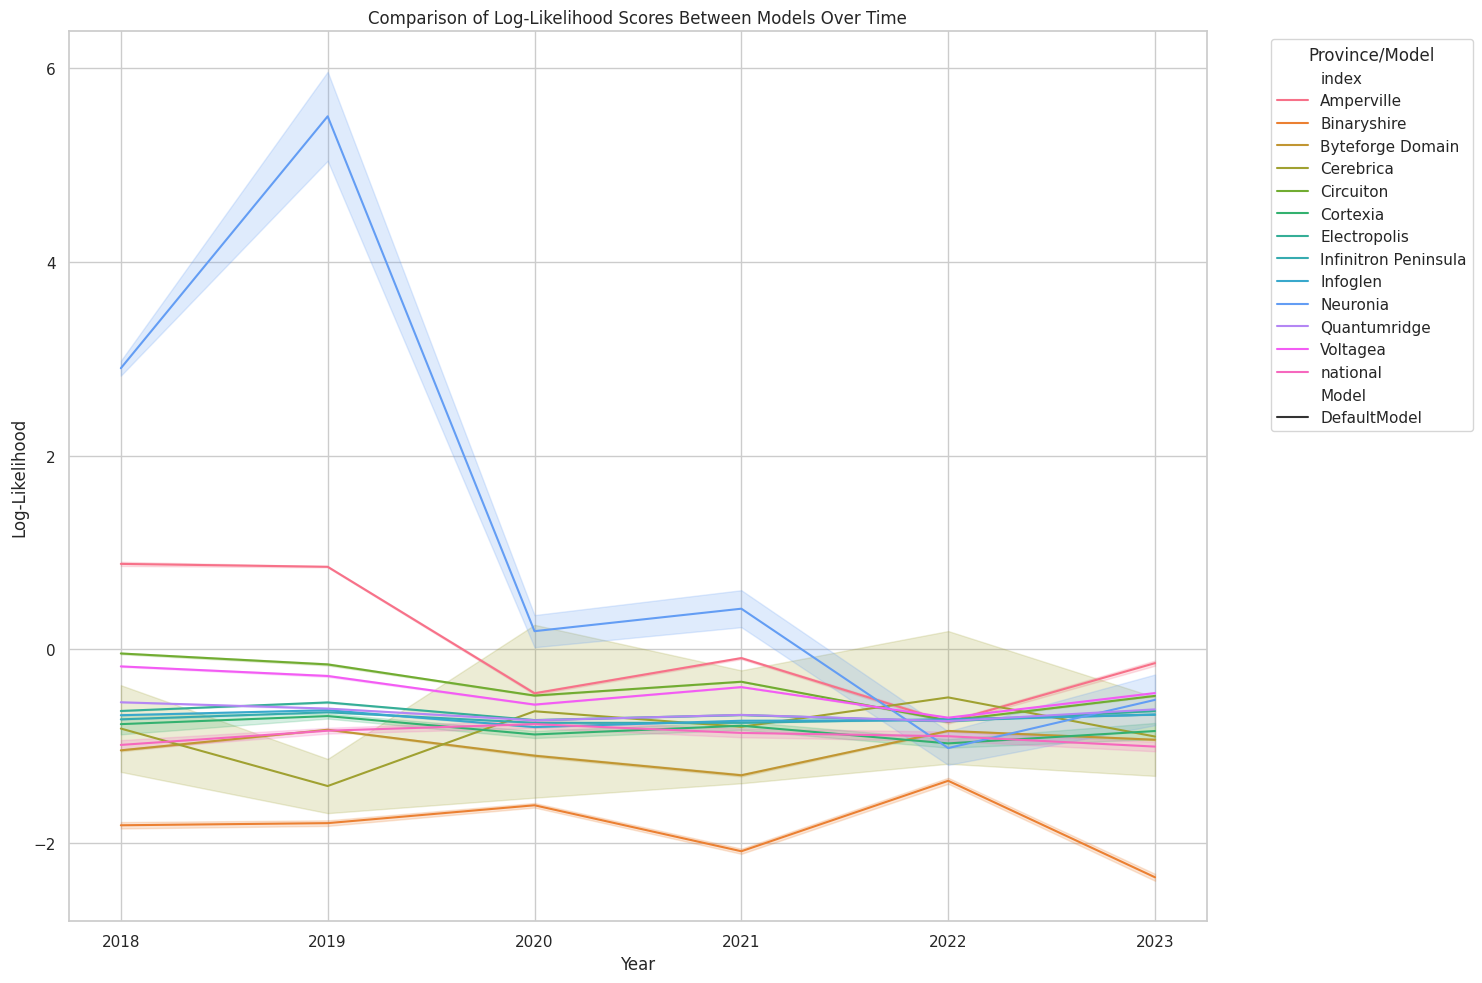

In [9]:

default_model_name = 'MeanOfRVs'
date = '2023-10-29'
comparison_model_name = 'UniformSwitchPoints'
generate_comparison_plots(default_model_name, comparison_model_name, date)

In [5]:
# default_model_name = 'RedistributingPollsOnly'
# date = '2023-10-26'
# comparison_model_name = 'UpdatedPriors'
# generate_comparison_plots(default_model_name, comparison_model_name, date)

In [6]:
# default_model_name = 'UpdatedPriors'
# date = '2023-10-26'
# comparison_model_name = 'AlternativePollWeights'
# generate_comparison_plots(default_model_name, comparison_model_name, date)

In [7]:
# default_model_name = 'RedistributingPollsOnly'
# date = '2023-10-26'
# comparison_model_name = 'AlternativePollWeights'
# generate_comparison_plots(default_model_name, comparison_model_name, date)

In [1]:

# date = '2023-10-29'
# default_name = 'DefaultModel'
# new_name = 'MeanOfRVs' # InvMeanWeighting, InformedAlphas
# make_plots(default_name, new_name)

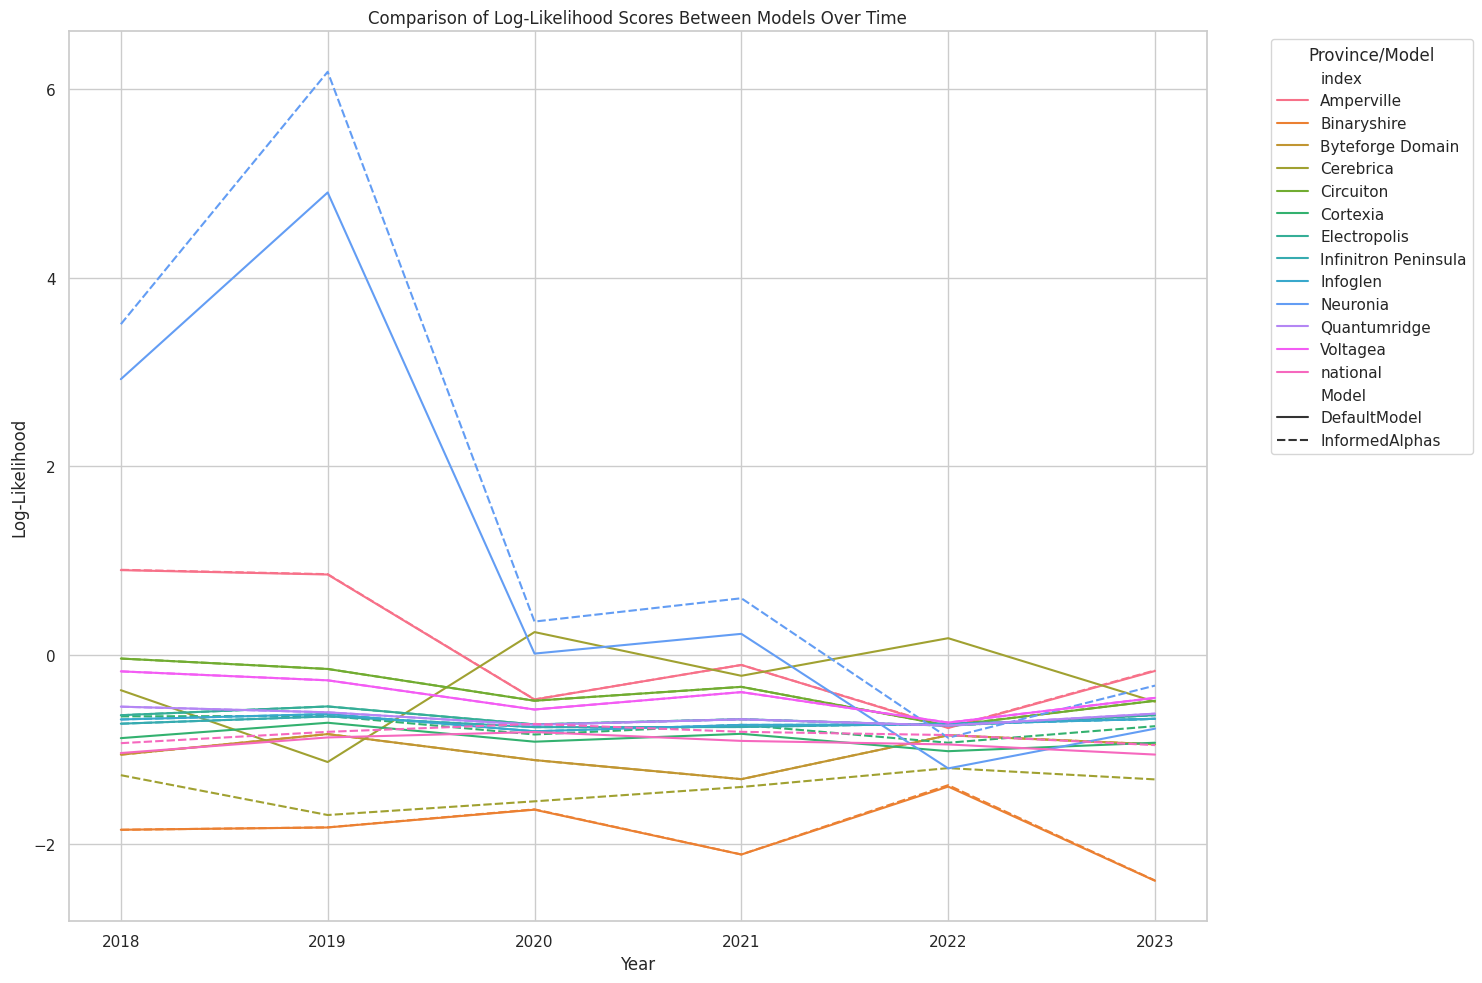

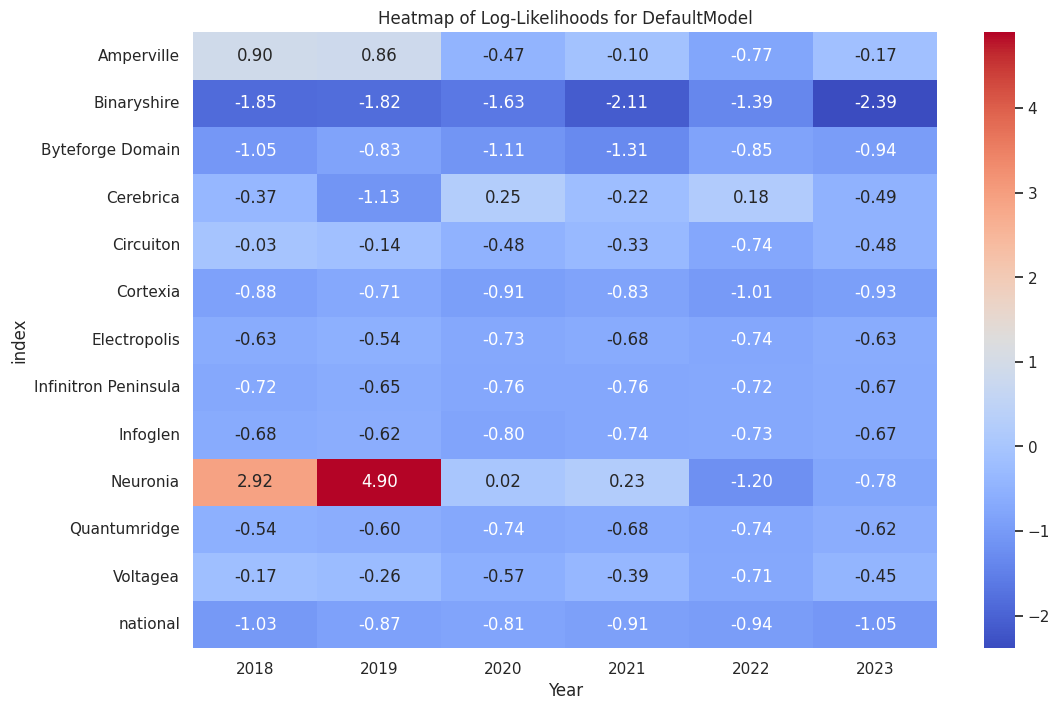

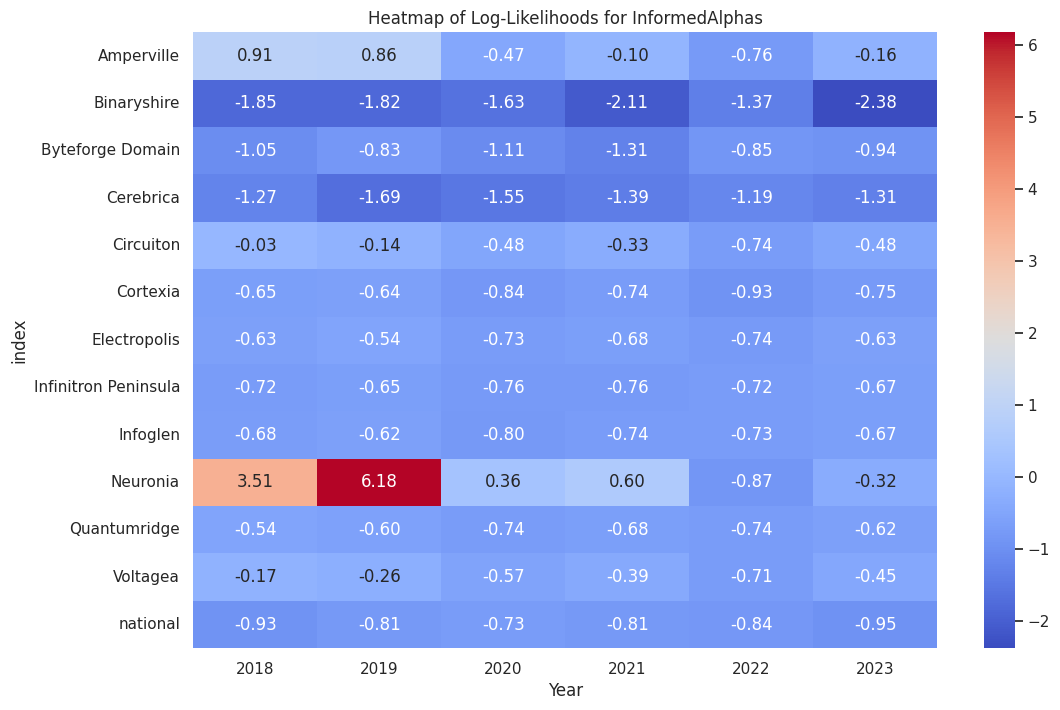

Model            DefaultModel  InformedAlphas
index      Year                              
Amperville 2018      0.902185        0.905981
           2019      0.856030        0.859756
           2020     -0.467577       -0.465885
           2021     -0.101400       -0.101734
           2022     -0.769132       -0.763967
...                       ...             ...
national   2019     -0.868990       -0.809548
           2020     -0.811596       -0.725906
           2021     -0.905698       -0.809448
           2022     -0.943111       -0.843692
           2023     -1.050371       -0.950366

[78 rows x 2 columns]


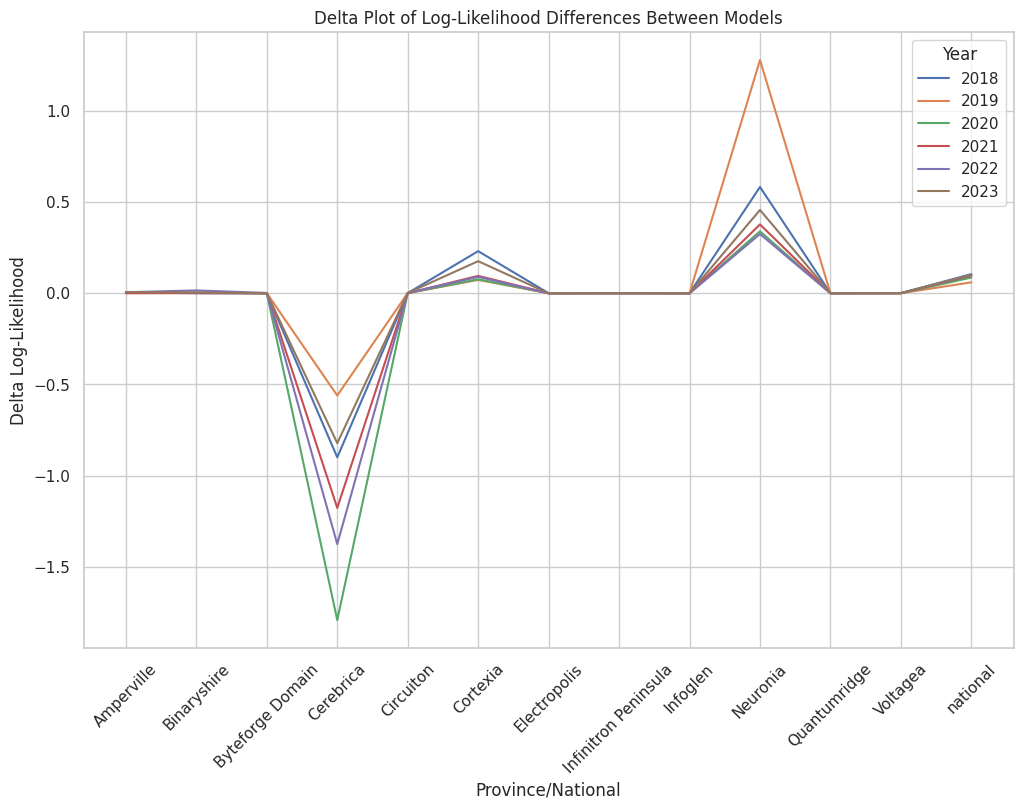

In [ ]:

date = '2023-10-29'
default_name = 'DefaultModel'
new_name = 'InformedAlphas' # InvMeanWeighting, InformedAlphas
make_plots(default_name, new_name)

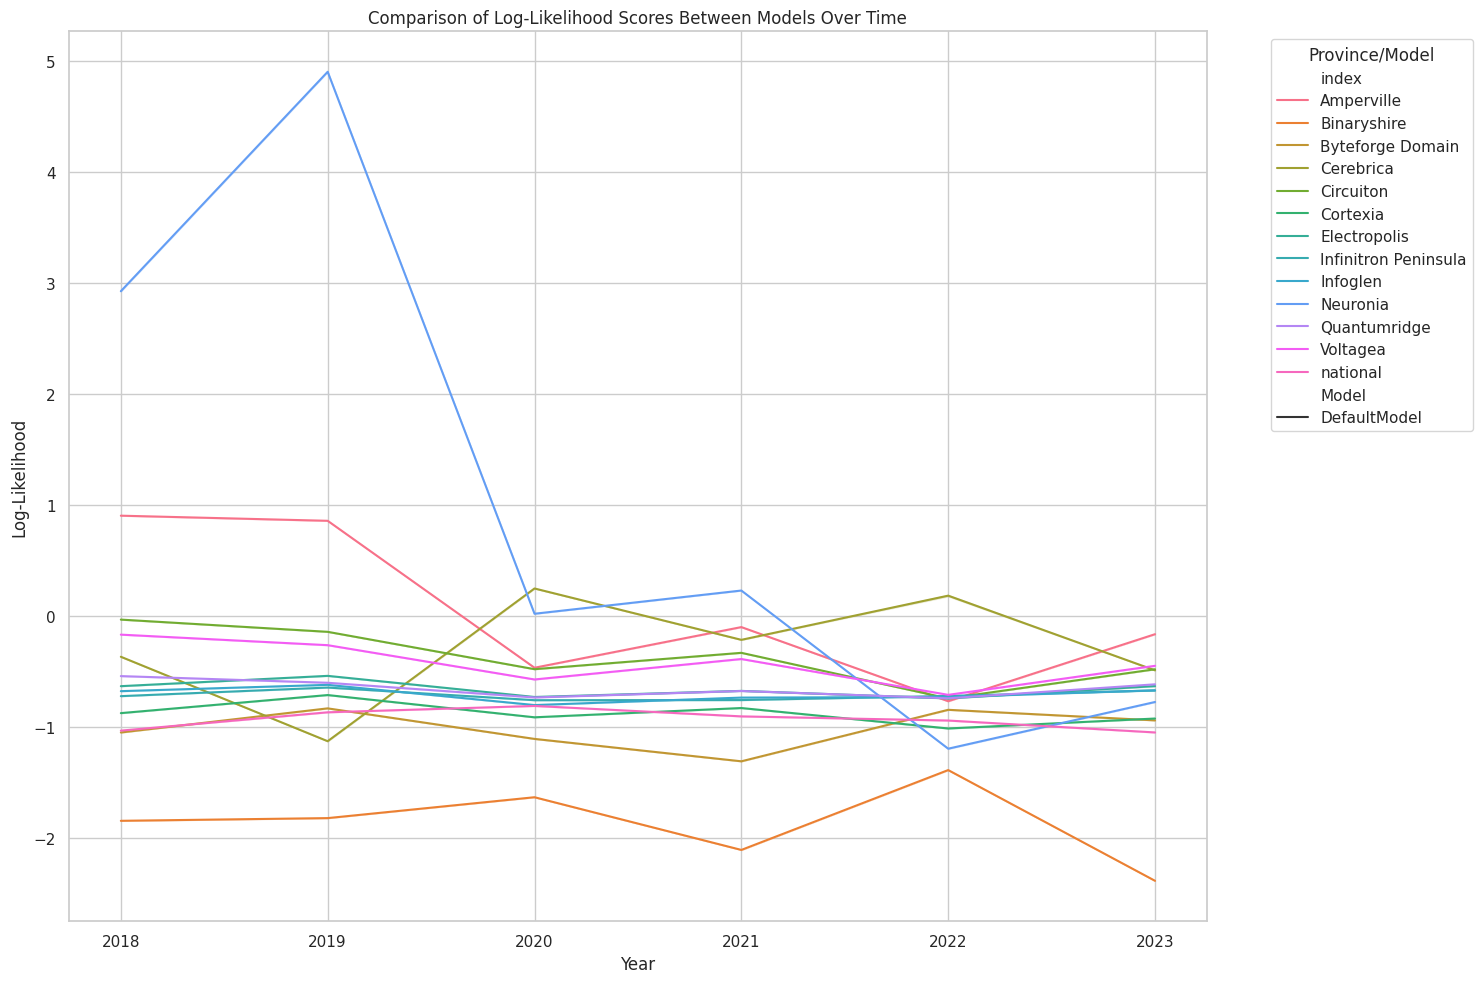

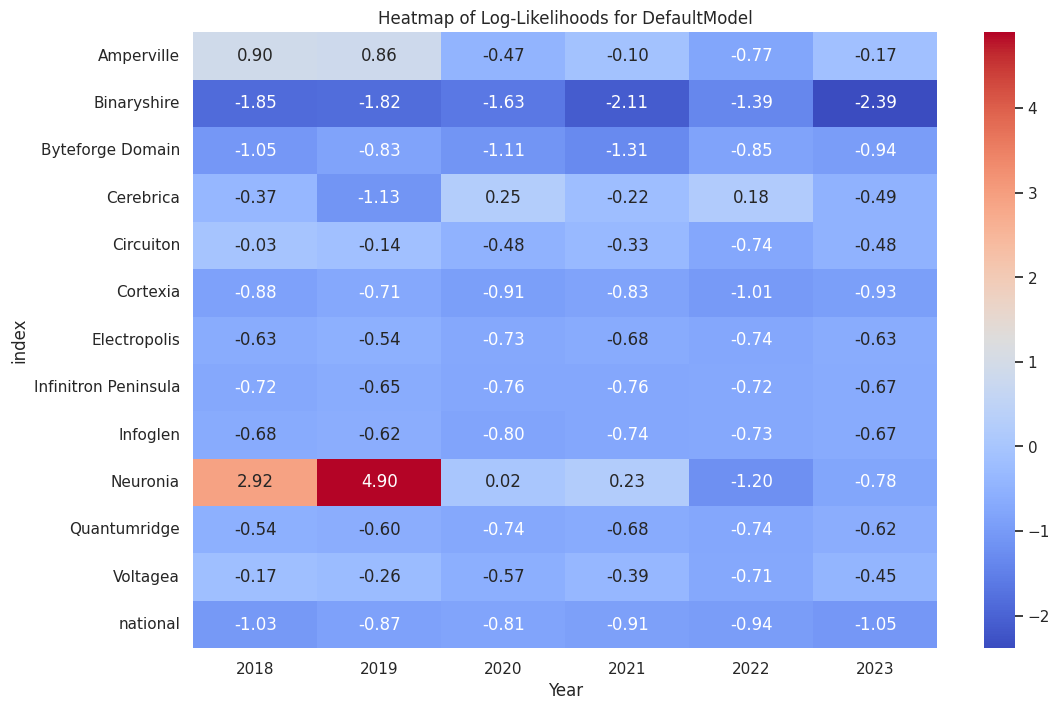

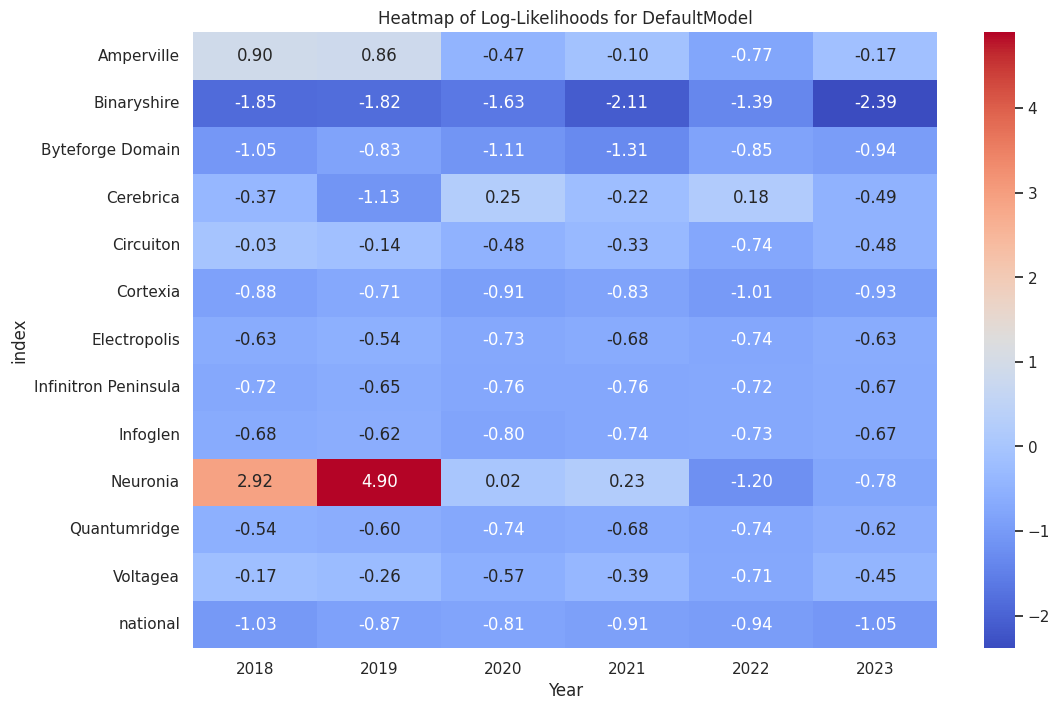

Model            DefaultModel
index      Year              
Amperville 2018      0.902185
           2019      0.856030
           2020     -0.467577
           2021     -0.101400
           2022     -0.769132
...                       ...
national   2019     -0.868990
           2020     -0.811596
           2021     -0.905698
           2022     -0.943111
           2023     -1.050371

[78 rows x 1 columns]


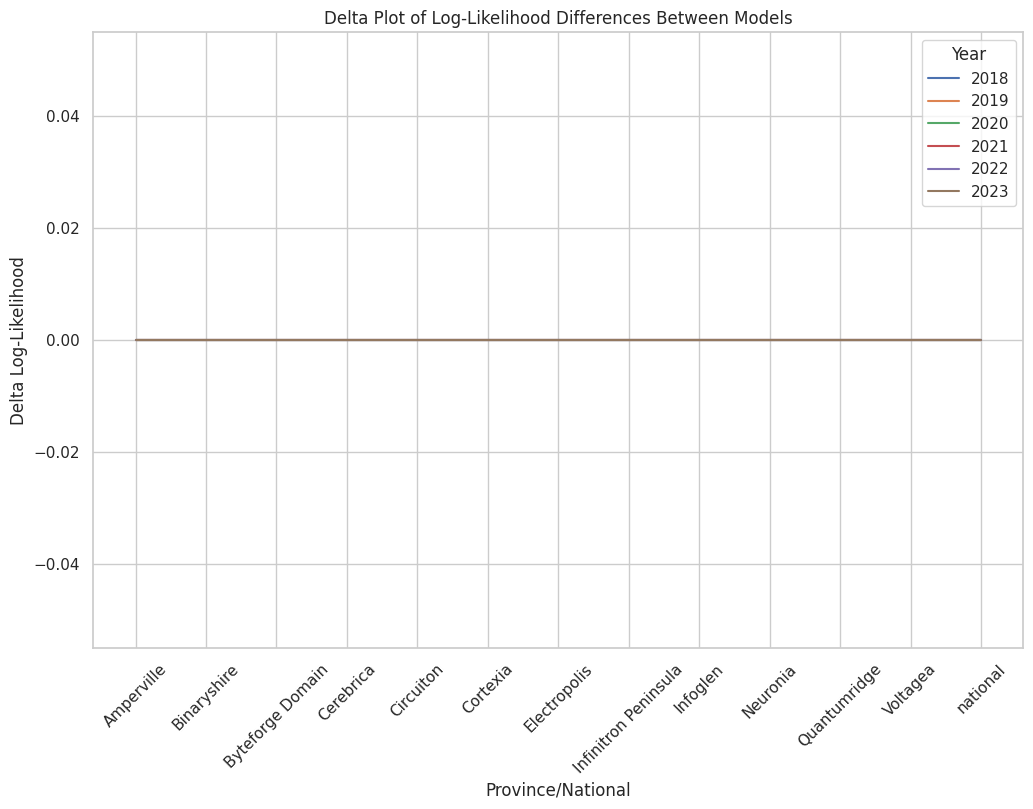

In [ ]:


date = '2023-10-29'
default_name = 'DefaultModel'
new_name = 'DefaultModel'
make_plots(default_name, new_name)

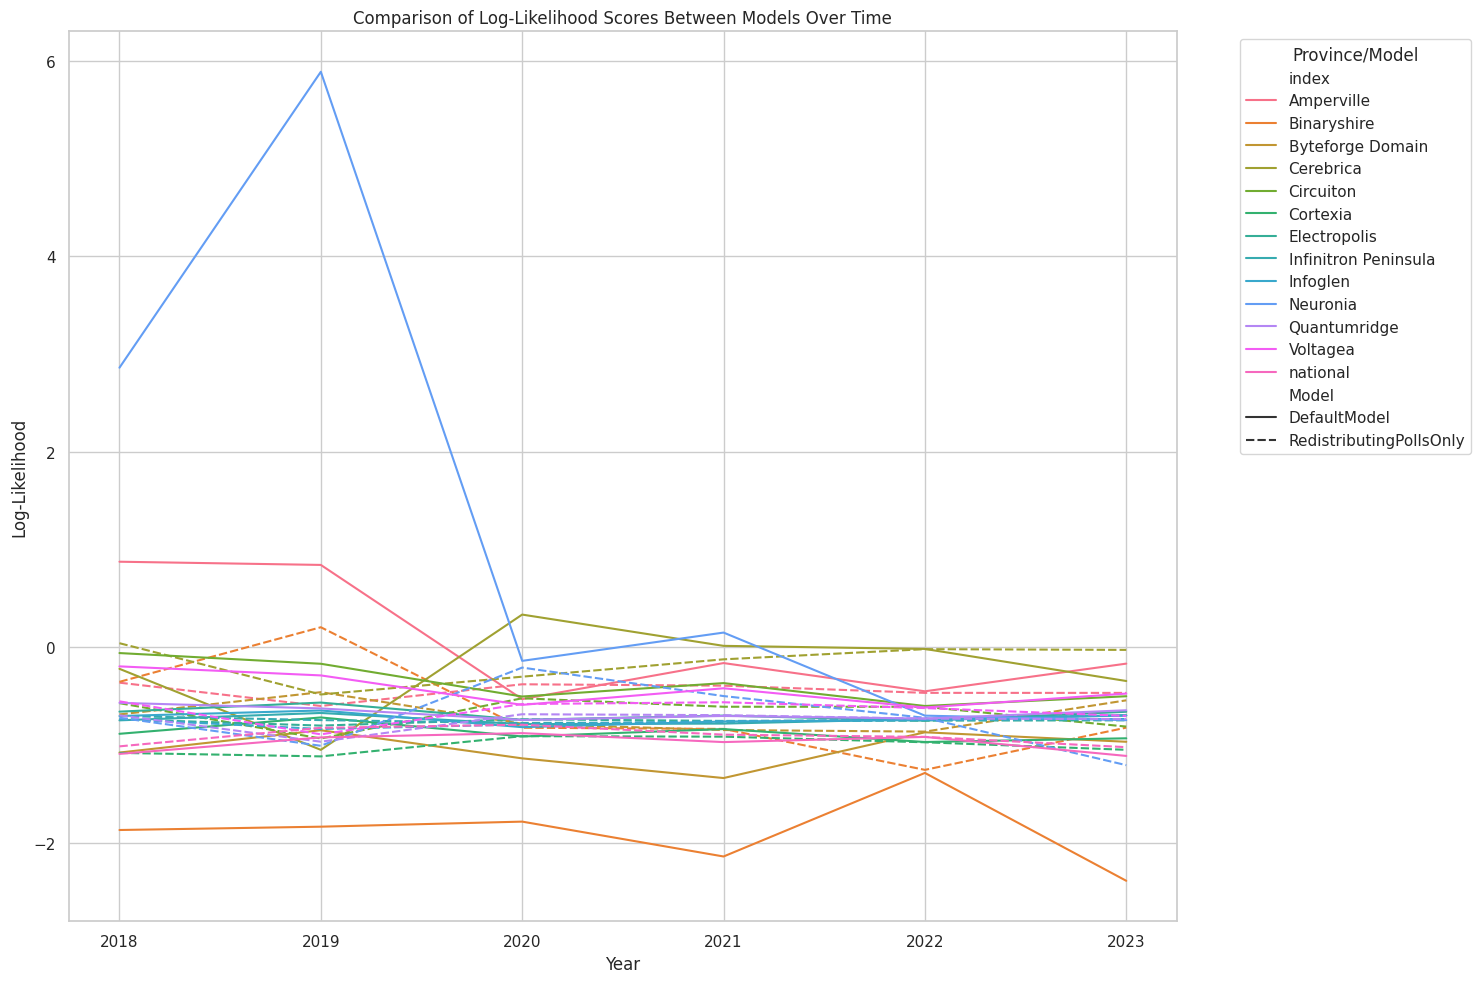

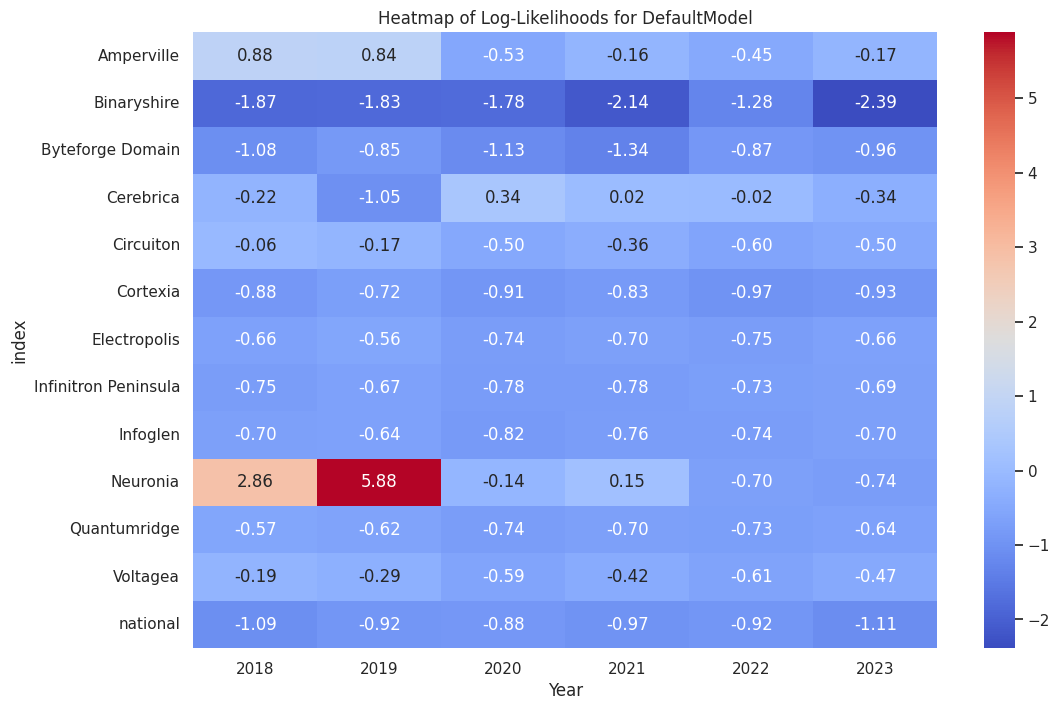

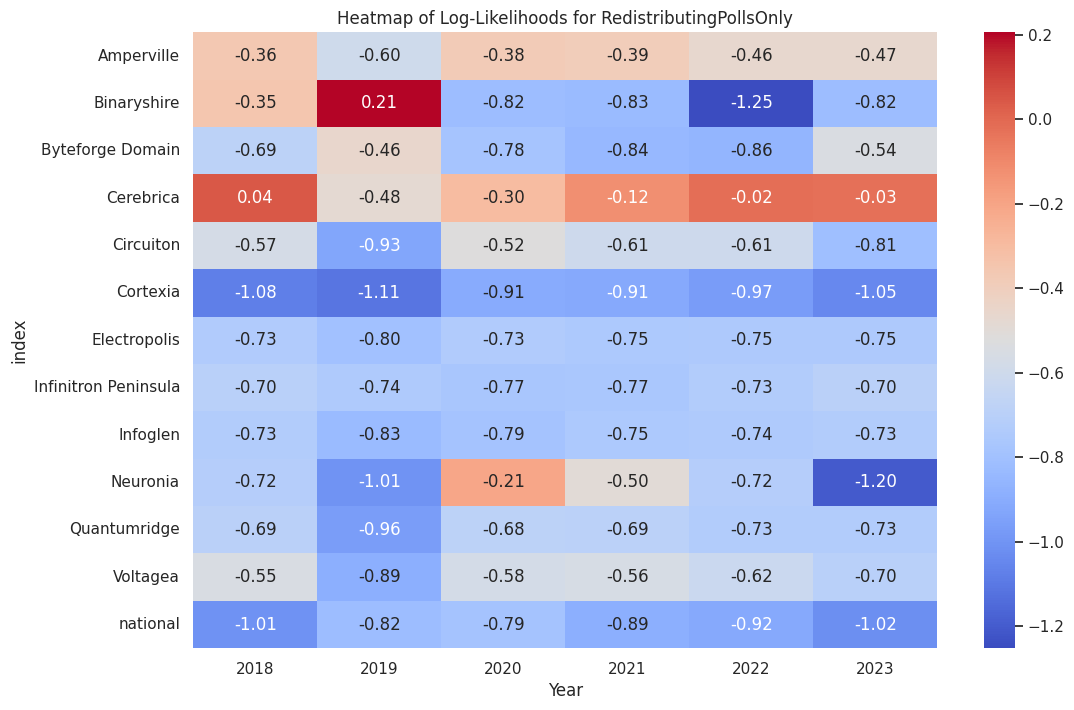

Model            DefaultModel  RedistributingPollsOnly
index      Year                                       
Amperville 2018      0.875985                -0.360623
           2019      0.843182                -0.598807
           2020     -0.528683                -0.377015
           2021     -0.160182                -0.391207
           2022     -0.448768                -0.464727
...                       ...                      ...
national   2019     -0.920155                -0.822161
           2020     -0.876548                -0.790607
           2021     -0.967902                -0.891901
           2022     -0.915172                -0.915081
           2023     -1.109497                -1.019985

[78 rows x 2 columns]


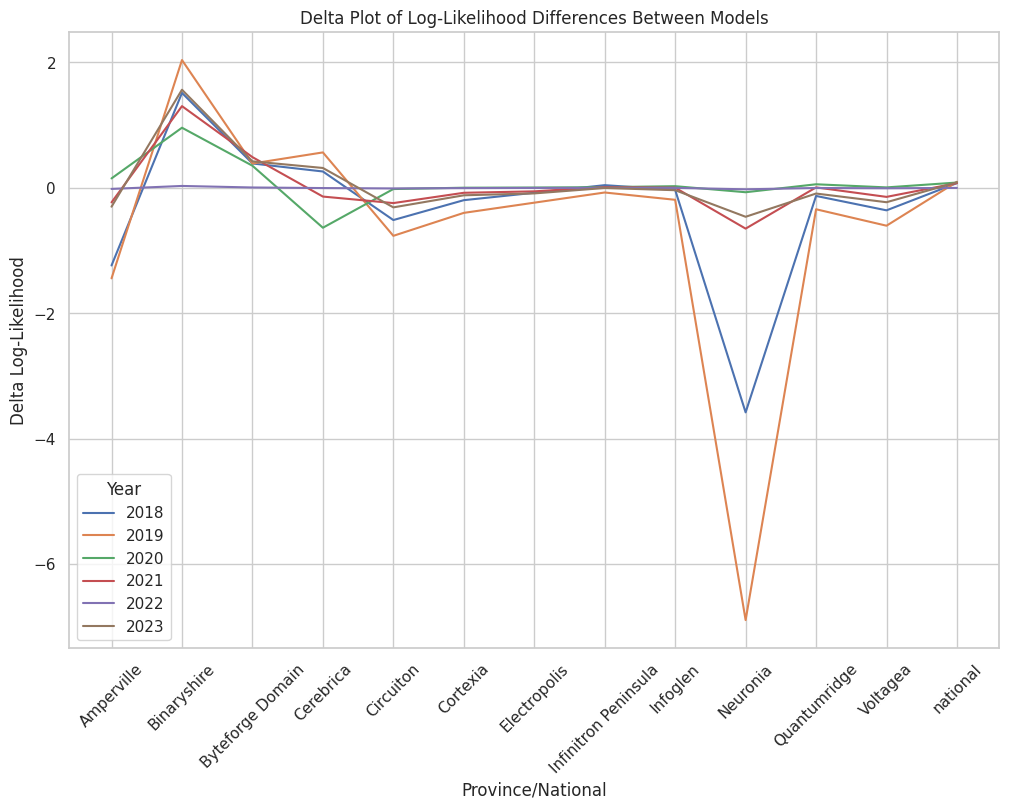

In [ ]:
default_model_name = 'RedistributingPollsOnly'
date = '2023-10-26'
comparison_model_name = 'AlternativePollWeights'
make_plots(default_name, new_name)



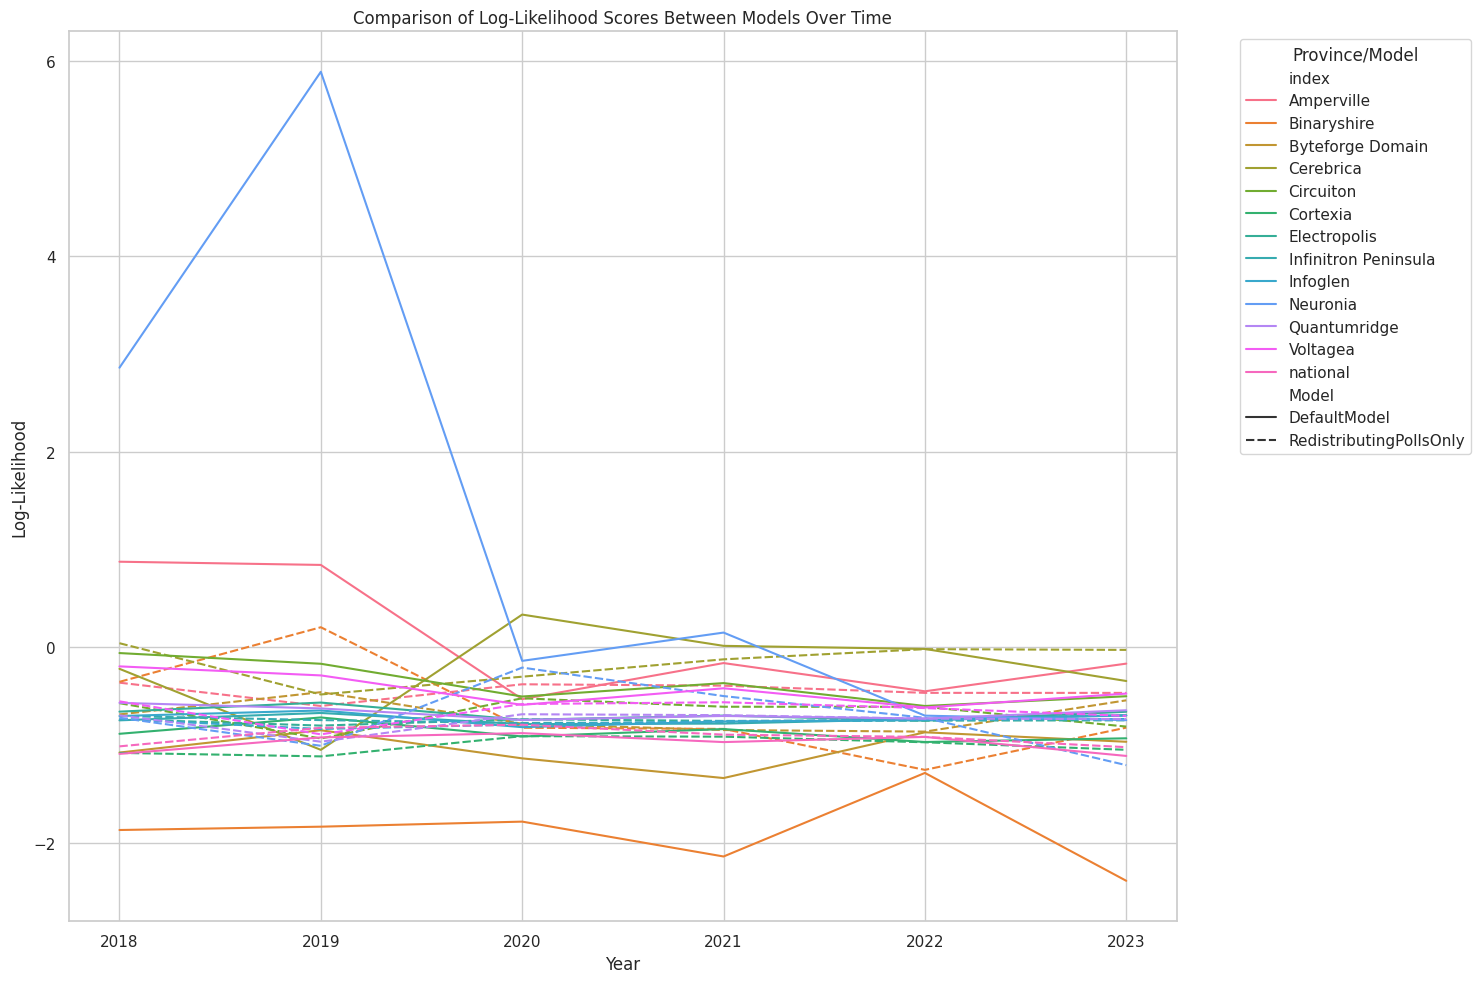

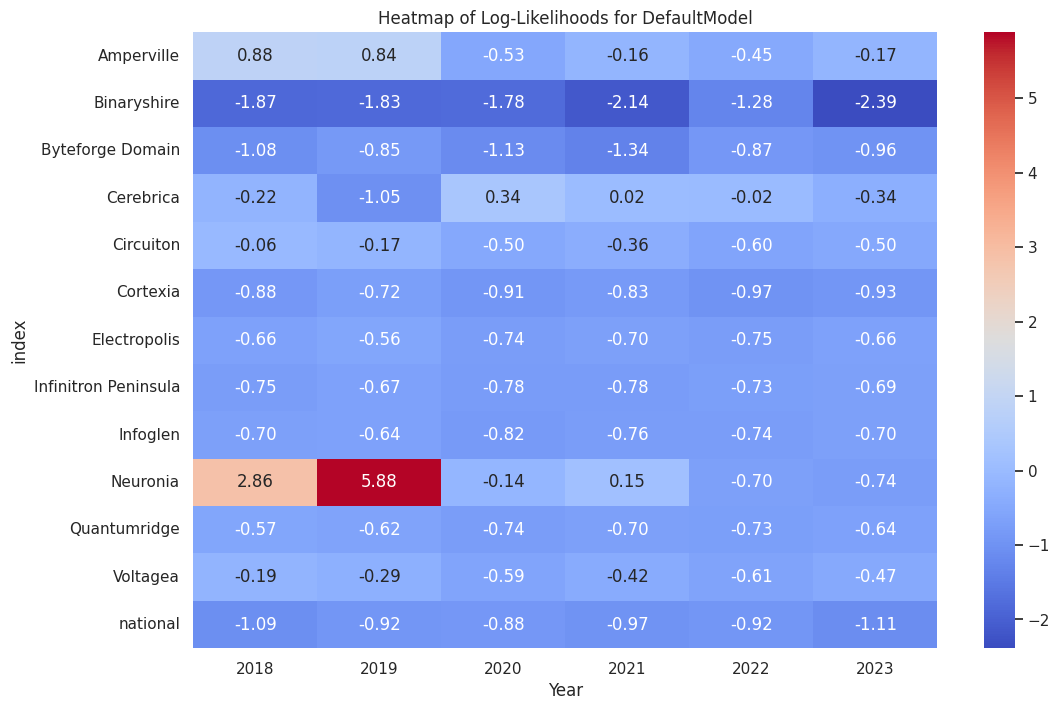

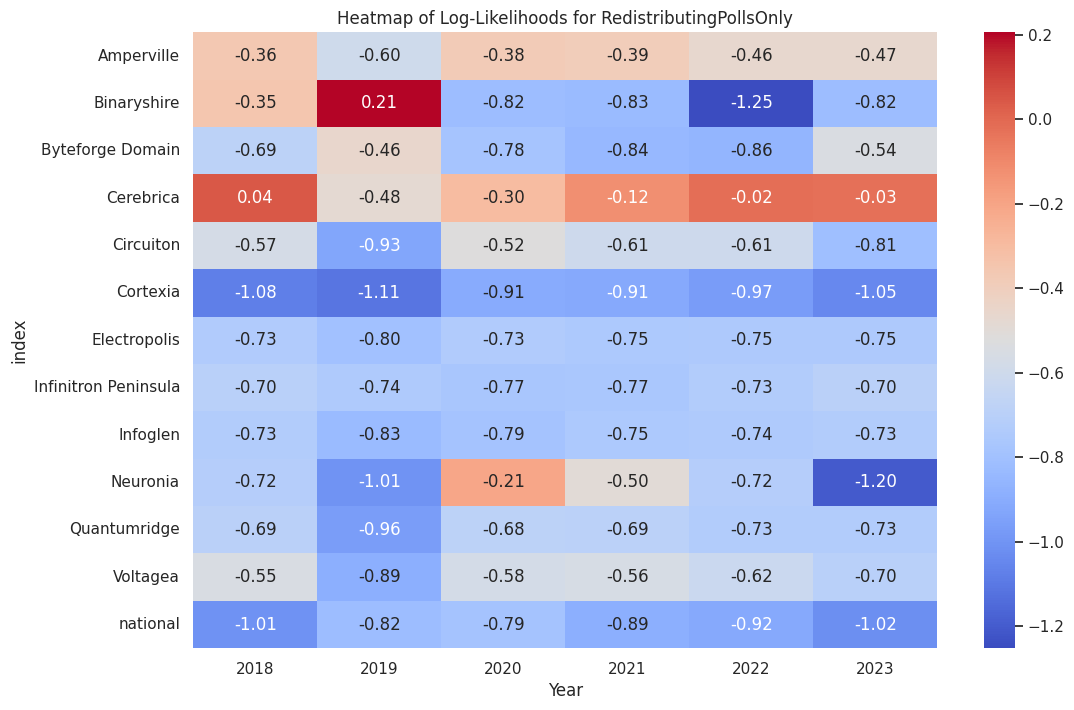

Model            DefaultModel  RedistributingPollsOnly
index      Year                                       
Amperville 2018      0.875985                -0.360623
           2019      0.843182                -0.598807
           2020     -0.528683                -0.377015
           2021     -0.160182                -0.391207
           2022     -0.448768                -0.464727
...                       ...                      ...
national   2019     -0.920155                -0.822161
           2020     -0.876548                -0.790607
           2021     -0.967902                -0.891901
           2022     -0.915172                -0.915081
           2023     -1.109497                -1.019985

[78 rows x 2 columns]


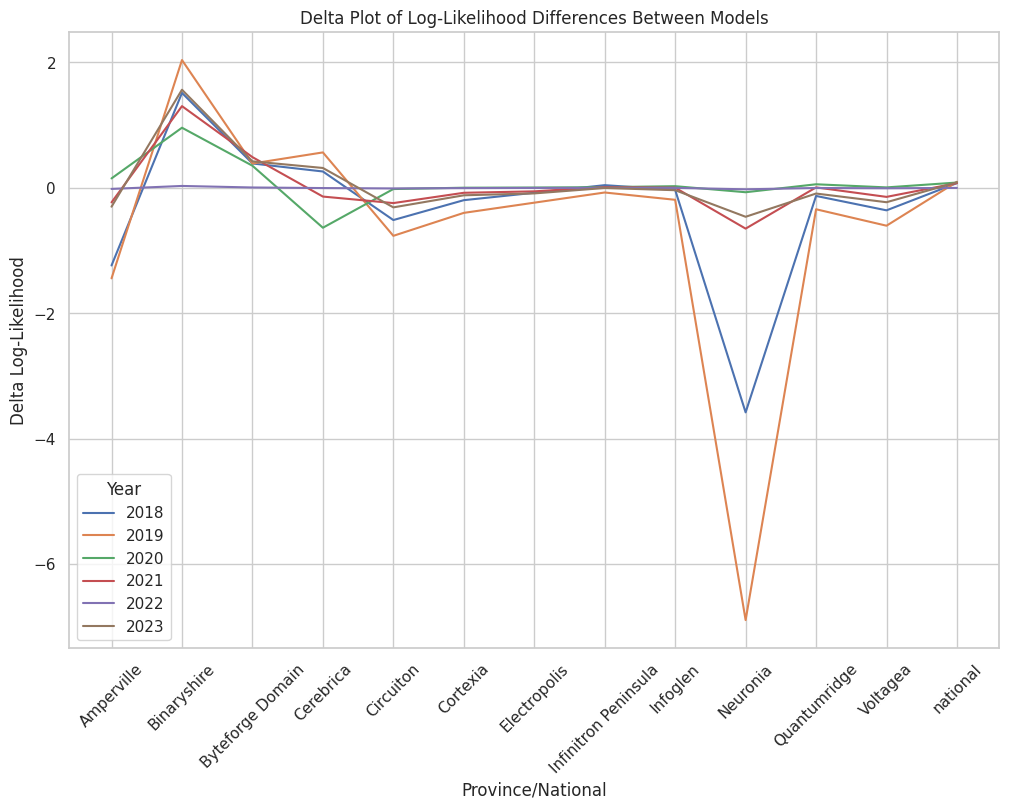

In [ ]:
default_model_name = 'UpdatedPriors'
date = '2023-10-26'
comparison_model_name = 'AlternativePollWeights'
make_plots(default_name, new_name)

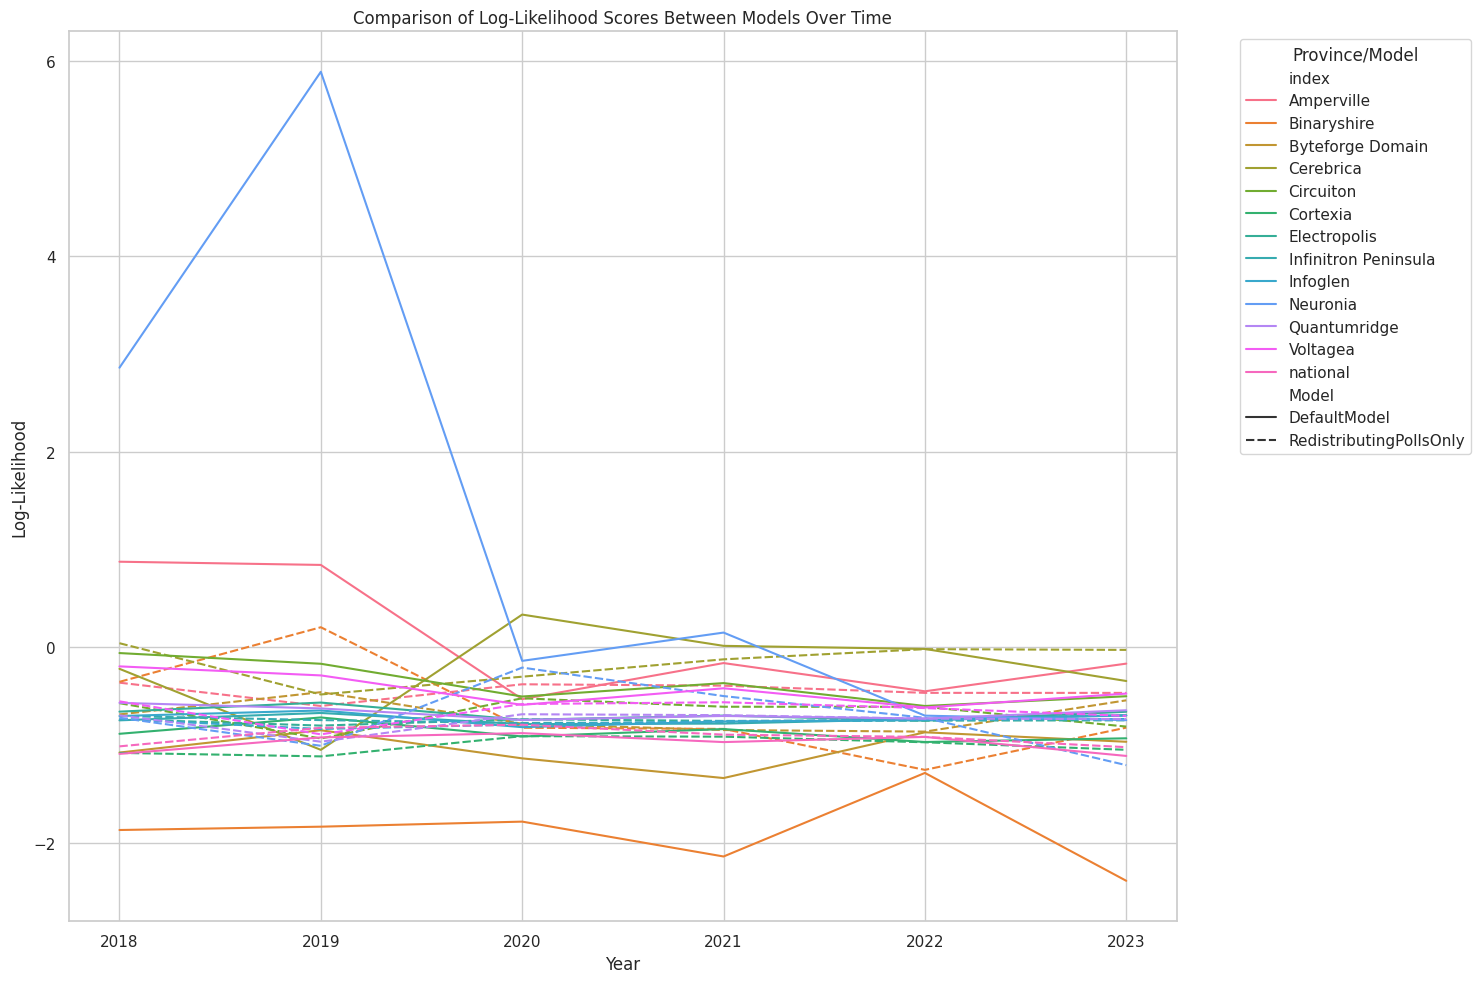

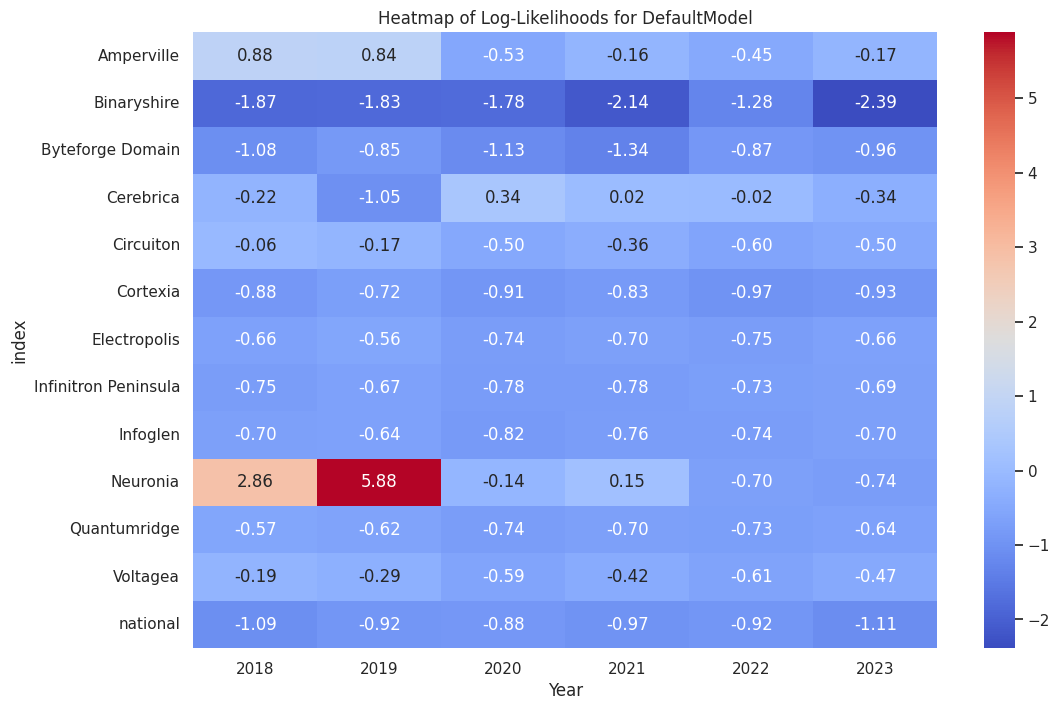

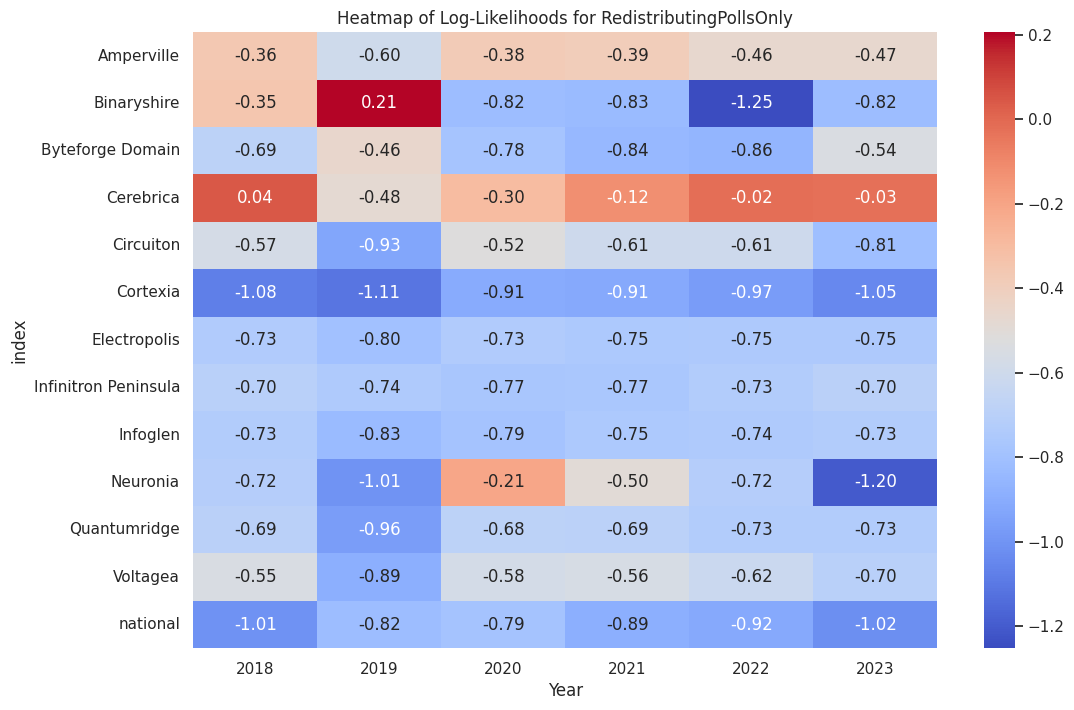

Model            DefaultModel  RedistributingPollsOnly
index      Year                                       
Amperville 2018      0.875985                -0.360623
           2019      0.843182                -0.598807
           2020     -0.528683                -0.377015
           2021     -0.160182                -0.391207
           2022     -0.448768                -0.464727
...                       ...                      ...
national   2019     -0.920155                -0.822161
           2020     -0.876548                -0.790607
           2021     -0.967902                -0.891901
           2022     -0.915172                -0.915081
           2023     -1.109497                -1.019985

[78 rows x 2 columns]


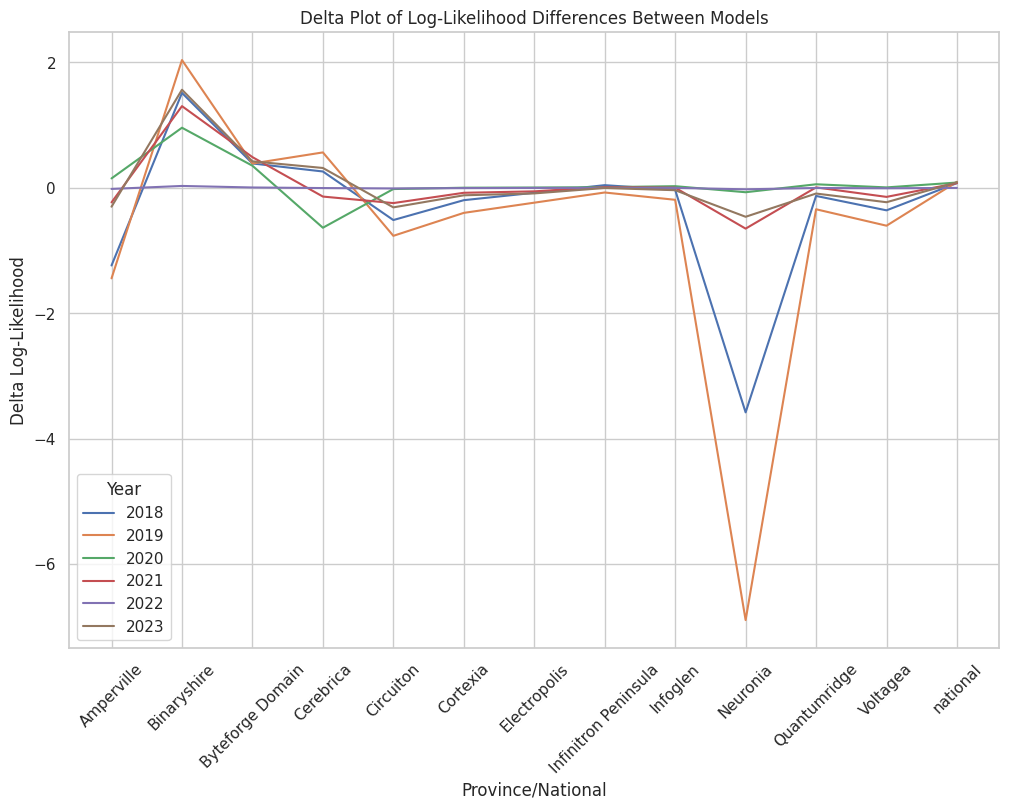

In [ ]:
default_model_name = 'RedistributingPollsOnly'
date = '2023-10-26'
comparison_model_name = 'UpdatedPriors'
make_plots(default_name, new_name)